In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")
from chiseling.dgps.nonneg_rct import NonNegRCT

### Formatting

In [2]:
# FORMATTING SETTINGS HERE

### Preprocessing

In [3]:
task_array_path = "../../task_arrays/linear_nonneg_rct.tasks.tsv"
res_path = "../../../output/linear_nonneg_rct/linear_nonneg_rct.combined.tsv"

In [4]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [5]:
# Aggregate results
setting_identifiers = ["d", "q", "tau", "strategy", "margin_width",
                       "n_burn_in", "alpha_init"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

In [6]:
# Add an ID for methods
method_identifiers = ["strategy", "margin_width", "n_burn_in", "alpha_init"]
agg_res_df.loc[:,"method_id"] = agg_res_df.loc[:,method_identifiers].apply(lambda row: "_".join([str(el) for el in row]), axis=1)

In [7]:
# Toggle alpha_init for visualization purposes
agg_res_df = agg_res_df[(agg_res_df.strategy == "TTestStrategy") | (agg_res_df.alpha_init == 0.025)]
# agg_res_df = agg_res_df[(agg_res_df.strategy == "TTestStrategy") | (agg_res_df.alpha_init == 0)]

### Settings

In [8]:
q_space = [0.1,0.3,0.5,0.8,1]

### Visualizations

Expected utility

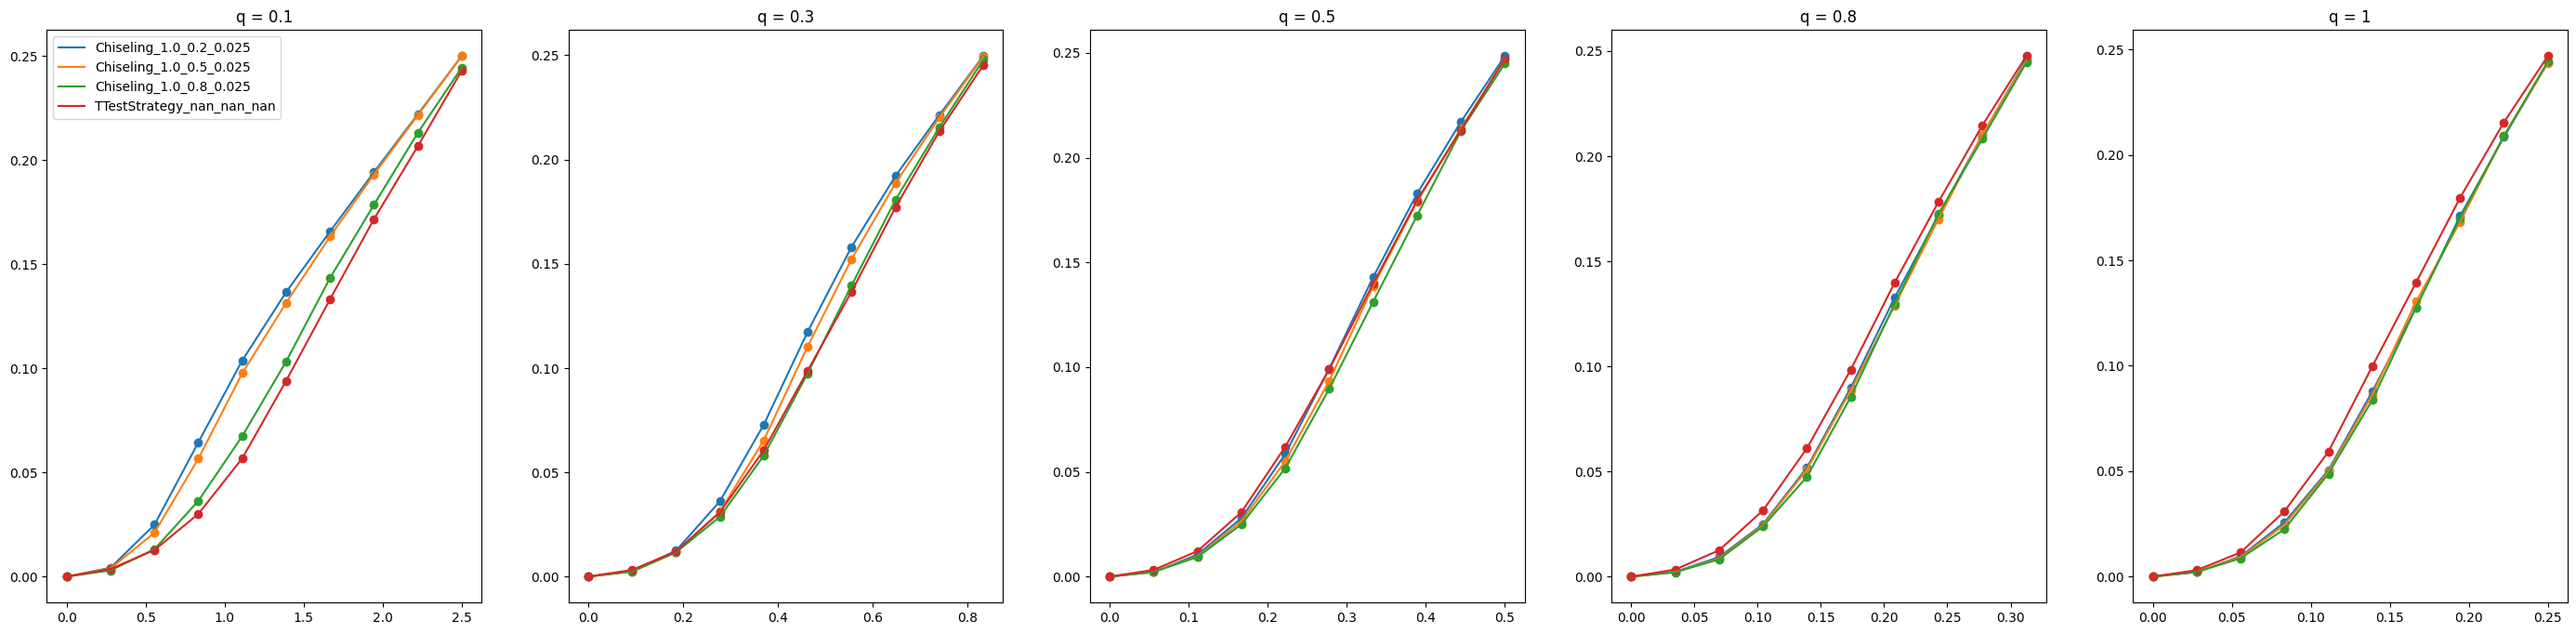

In [9]:
fig, ax = plt.subplots(1,len(q_space),figsize=(7 * len(q_space),8))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for q in q_space:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.q == q]
    # Loop through methods
    for method_id in sub_res_df.method_id.unique():
        sub_sub_res_df = sub_res_df[sub_res_df.method_id == method_id].sort_values("tau")
        ax[AX0].plot(sub_sub_res_df.tau, sub_sub_res_df.subgroup_utility_mean,
                     label=method_id)
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.tau, sub_sub_res_df.subgroup_utility_mean,
                        color=last_color)
    # Add title
    ax[AX0].set_title("q = {}".format(q))
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

Power

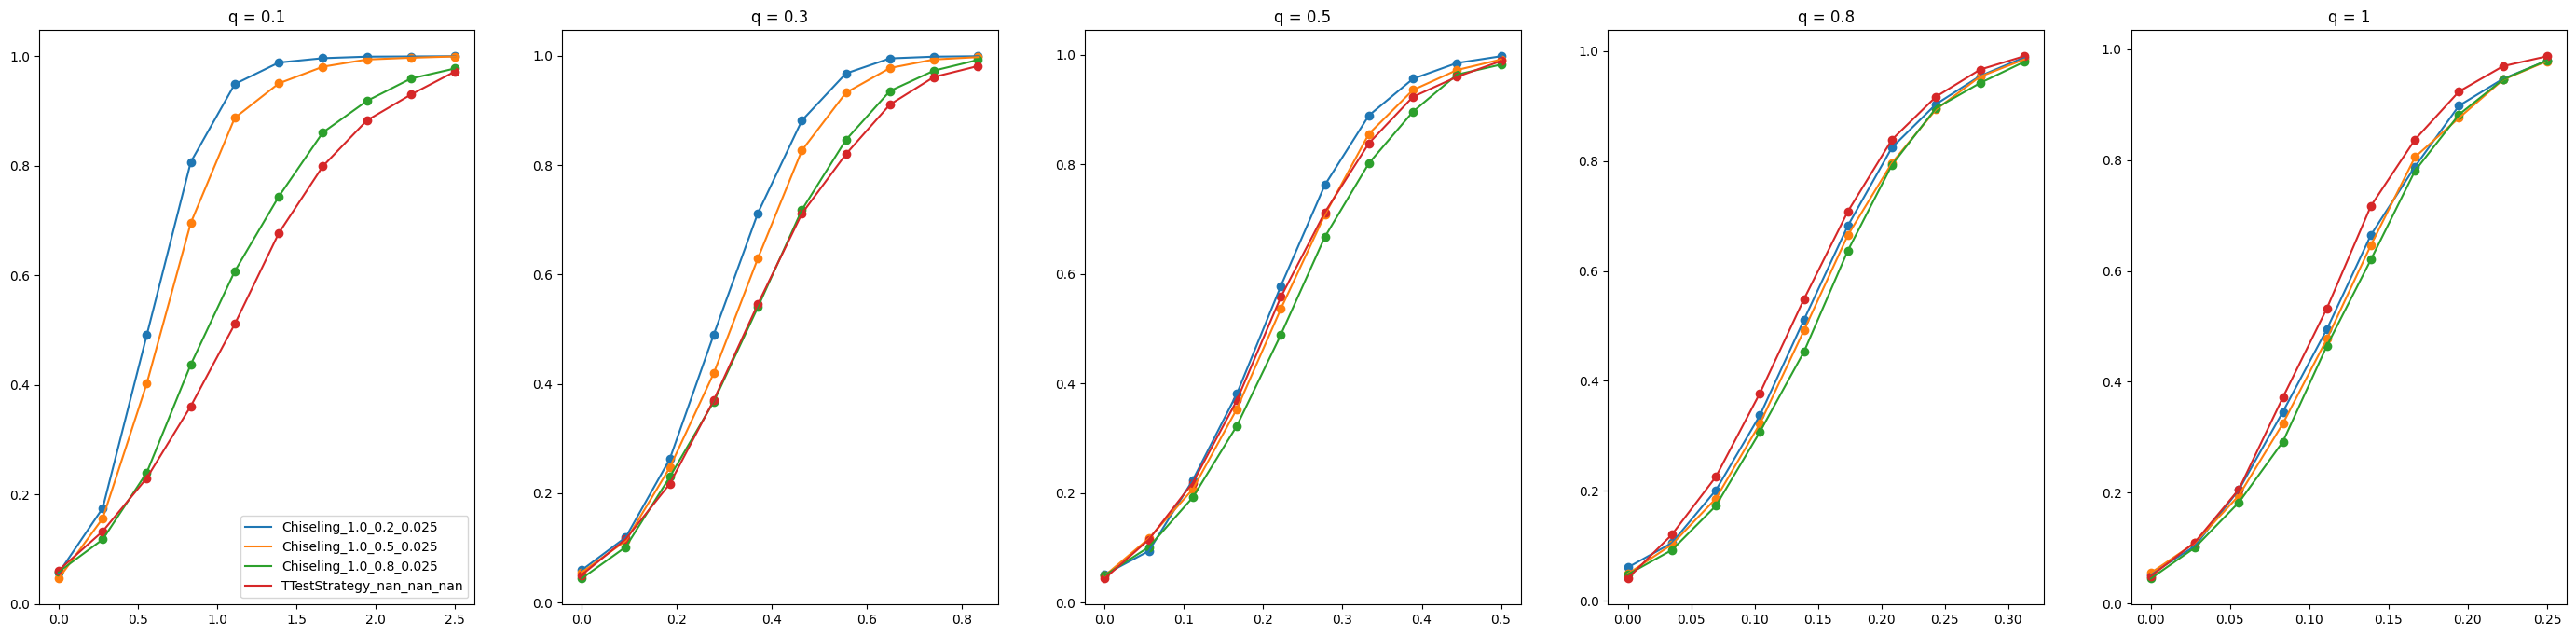

In [10]:
fig, ax = plt.subplots(1,len(q_space),figsize=(7 * len(q_space),8))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for q in q_space:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.q == q]
    # Loop through methods
    for method_id in sub_res_df.method_id.unique():
        sub_sub_res_df = sub_res_df[sub_res_df.method_id == method_id].sort_values("tau")
        ax[AX0].plot(sub_sub_res_df.tau, sub_sub_res_df.rejected_mean,
                     label=method_id)
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.tau, sub_sub_res_df.rejected_mean,
                        color=last_color)
    # Add title
    ax[AX0].set_title("q = {}".format(q))
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

### Type I error

In [11]:
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [12]:
setting_identifiers = ["d", "q", "tau", "strategy", "margin_width",
                       "n_burn_in", "alpha_init"]
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

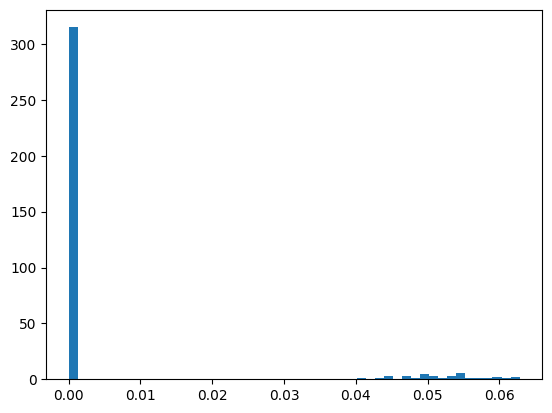

Min = 0.0 / Max = 0.0628


In [13]:
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))